# 20기 KNN 정규세션 과제

- 제출자: 20기 황태연
- 제출 일자: 2023.08.15. (화)

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

# 0. 데이터 불러오기

In [12]:
import pandas as pd
df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


# 1. Preprocssing / EDA

## 1.1. 데이터 정보 확인

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          3465 non-null   float64
 10  Product_Category_3          1544 non-null   float64
 11  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 507.6+ KB


In [21]:
print('Product_Category_2 유효 데이터 비율:', 3465/4998 * 100, '%')
print('Product_Category_3 유효 데이터 비율:', 1544/4998 * 100, '%')

Product_Category_2 유효 데이터 비율: 69.32773109243698 %
Product_Category_3 유효 데이터 비율: 30.89235694277711 %


- Product_Category_2와 Product_Category_3은 각각 약 69%, 31%의 데이터만 유효합니다. 이 데이터를 모두 포함시키면 결측치가 상당히 많아져서 대부분의 데이터가 손실되므로, 분석 시 해당 데이터는 제외하겠습니다.

In [14]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,4.998000e+03,4998.000000,4998.000000,4998.000000,3465.000000,1544.000000,4998.000000
mean,1.003015e+06,8.036815,0.421369,5.320128,9.773737,12.766839,9234.655462
std,1.709910e+03,6.442697,0.493828,3.912281,5.101867,4.023591,4999.225081
min,1.000003e+06,0.000000,0.000000,1.000000,2.000000,3.000000,13.000000
25%,1.001560e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5497.750000
50%,1.003040e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8049.000000
75%,1.004417e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12039.000000
max,1.006037e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23913.000000


In [18]:
for col in df.columns:
    print('['+col+']')
    print(df[col].value_counts())

[User_ID]
1002063    12
1005795    12
1001980    11
1004344    11
1006036    10
           ..
1004980     1
1004385     1
1004138     1
1002648     1
1000837     1
Name: User_ID, Length: 2656, dtype: int64
[Product_ID]
P00265242    21
P00220442    16
P00114942    15
P00010742    15
P00148642    15
             ..
P00072342     1
P00037842     1
P00207042     1
P00129742     1
P00358242     1
Name: Product_ID, Length: 1797, dtype: int64
[Gender]
M    3765
F    1233
Name: Gender, dtype: int64
[Age]
26-35    1996
36-45    1000
18-25     906
46-50     414
51-55     350
55+       195
0-17      137
Name: Age, dtype: int64
[Occupation]
4     706
0     572
7     535
1     460
17    339
12    305
20    285
2     251
14    245
16    244
6     186
3     160
15    133
10    122
5      98
11     95
19     73
13     65
18     56
9      50
8      18
Name: Occupation, dtype: int64
[City_Category]
B    2102
C    1555
A    1341
Name: City_Category, dtype: int64
[Stay_In_Current_City_Years]
1     1758
2 

- User_ID와 Product_ID는 일반적으로 Purchase와 관련 있다고 보기 어렵습니다.
    - 새로운 User 또는 Product에 대해서는 새로운 User_ID와 Product_ID가 부여되기 때문입니다.
- 이에 따라 다음과 같이 목적 변수와 설명 변수를 설정하는 것이 적합해보입니다.
    - **목적 변수**: Purchase
    - **설명 변수**: User_ID와 Product_ID, Product_Category_2, Product_Category_3, 목적 변수를 제외한 모든 변수

- 각 설명 변수를 Categorical 변수와 Numerical 변수로 구분하면 다음과 같습니다.
    - **Categorical Variables**: Gender, Age, Occupation(직업), City_Category, Stay_In_Current_City_Years, Marital_Status, Product_Category_1
    - **Numerical Variables**: (없음)
- 특히 Categorical Variables 중 binary Variable인 것은 다음과 같습니다.
    - **Binary Variables**: Gender, Marital_Status

- 위 정보를 모두 반영하여 데이터를 전처리합시다.

## 1.2. 데이터 전처리

### 1.2.1. 불필요한 데이터 제거

- 'User_ID', 'Product_ID', 'Product_Category_2', 'Product_Category_3' 데이터 행을 제거합니다.

In [25]:
df_removed = df.drop(['User_ID', 'Product_ID', 'Product_Category_2', 'Product_Category_3'], axis=1)
df_removed

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Purchase
0,F,0-17,10,A,3,0,5,2010
1,F,0-17,10,A,1,0,7,4483
2,F,0-17,10,A,1,0,1,7696
3,F,0-17,10,A,3,0,2,16429
4,F,0-17,10,A,3,0,3,5780
...,...,...,...,...,...,...,...,...
4993,M,55+,7,C,1,1,1,11701
4994,M,55+,1,C,1,1,8,2045
4995,M,55+,13,C,3,1,1,4505
4996,M,55+,0,C,2,1,12,1413


### 1.2.2. 원-핫-인코딩

- Categorical Variables는 모두 원-핫-인코딩(One-hot-encoding)하여 수치형 변수처럼 바꾸어주어야 합니다.

In [30]:
one_hot_columns = ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1']
df_encoded = pd.get_dummies(df_removed, columns=one_hot_columns)
df_encoded

,Purchase,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,...,Product_Category_1_11,Product_Category_1_12,Product_Category_1_13,Product_Category_1_14,Product_Category_1_15,Product_Category_1_16,Product_Category_1_17,Product_Category_1_18,Product_Category_1_19,Product_Category_1_20
0,2010,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4483,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7696,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16429,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5780,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,11701,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4994,2045,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4995,4505,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4996,1413,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [31]:
df_encoded.columns

Index(['Purchase', 'Gender_F', 'Gender_M', 'Age_0-17', 'Age_18-25',
       'Age_26-35', 'Age_36-45', 'Age_46-50', 'Age_51-55', 'Age_55+',
       'Occupation_0', 'Occupation_1', 'Occupation_2', 'Occupation_3',
       'Occupation_4', 'Occupation_5', 'Occupation_6', 'Occupation_7',
       'Occupation_8', 'Occupation_9', 'Occupation_10', 'Occupation_11',
       'Occupation_12', 'Occupation_13', 'Occupation_14', 'Occupation_15',
       'Occupation_16', 'Occupation_17', 'Occupation_18', 'Occupation_19',
       'Occupation_20', 'City_Category_A', 'City_Category_B',
       'City_Category_C', 'Stay_In_Current_City_Years_0',
       'Stay_In_Current_City_Years_1', 'Stay_In_Current_City_Years_2',
       'Stay_In_Current_City_Years_3', 'Stay_In_Current_City_Years_4+',
       'Marital_Status_0', 'Marital_Status_1', 'Product_Category_1_1',
       'Product_Category_1_2', 'Product_Category_1_3', 'Product_Category_1_4',
       'Product_Category_1_5', 'Product_Category_1_6', 'Product_Category_1_7',
     

- Binary Variables을 원 핫 인코딩하면 2개의 변수가 발생하는데, 두 변수를 모두 사용하면 **다중공선성** 문제가 발생할 수 있습니다.
- 따라서 Binary Variables의 원 핫 인코딩 중 하나는 제거해주는 것이 좋습니다.

In [33]:
df_final = df_encoded.drop(['Gender_M', 'Marital_Status_1'], axis=1)
df_final

,Purchase,Gender_F,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Occupation_0,...,Product_Category_1_11,Product_Category_1_12,Product_Category_1_13,Product_Category_1_14,Product_Category_1_15,Product_Category_1_16,Product_Category_1_17,Product_Category_1_18,Product_Category_1_19,Product_Category_1_20
0,2010,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4483,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7696,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16429,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5780,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,11701,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4994,2045,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4995,4505,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4996,1413,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0


- 현재 설명 변수가 모두 범주형 변수이므로, 별도의 정규화는 하지 않겠습니다.

## 2. KNN 구현 & 파라미터 튜닝

### 2.1. KNN 구현

- 먼저 Training dataset와 Test dataset으로 구분합니다.

In [43]:
from sklearn.model_selection import train_test_split

X = df_final.drop(columns=['Purchase'])
y = df_final['Purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

- sklearn에 구현되어있는 KNN regression을 이용합니다.

In [45]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5, metric='minkowski') # 인접한 5개의 Euclidean 평균(minkowski)을 이용
model.fit(X_train, y_train)

KNeighborsRegressor()

- sklearn에서 제공하는 KNN regression의 평가 지표는 **결정계수(Coefficient of determination)**로, 식은 다음과 같습니다.
$$
R^2 = 1-\frac{\sum (y - \hat{y})^2}{\sum (y - \bar{y})^2}
$$
($y$: 정답, $\bar{y}$: 정답의 평균, $\hat{y}$: 예측)

- 0에 가까울수록 예측을 못한 것이고, 1에 가까울수록 예측을 잘 한 것입니다.

In [48]:
print(model.score(X_test, y_test))

0.30415101596248384


### 2.2. 하이퍼 파라미터 튜닝

- 위에서 구현한 KNN 모델을 이용해서 하이퍼 파라미터(n_neighbors, metric)를 조절해보겠습니다.

In [64]:
import numpy as np

train_scores_euclidean = []
test_scores_euclidean = []
train_scores_manhattan = []
test_scores_manhattan = []
for k in range(1, 51):
    model = KNeighborsRegressor(n_neighbors=k, p=2, metric='euclidean') # 인접한 k개의 Euclidean distance 이용
    model.fit(X_train, y_train)
    train_scores_euclidean.append(model.score(X_train, y_train))
    test_scores_euclidean.append(model.score(X_test, y_test))
    
    model = KNeighborsRegressor(n_neighbors=k, p=1, metric='manhattan') # 인접한 k개의 Manhattan distance 이용
    model.fit(X_train, y_train)
    train_scores_manhattan.append(model.score(X_train, y_train))
    test_scores_manhattan.append(model.score(X_test, y_test))

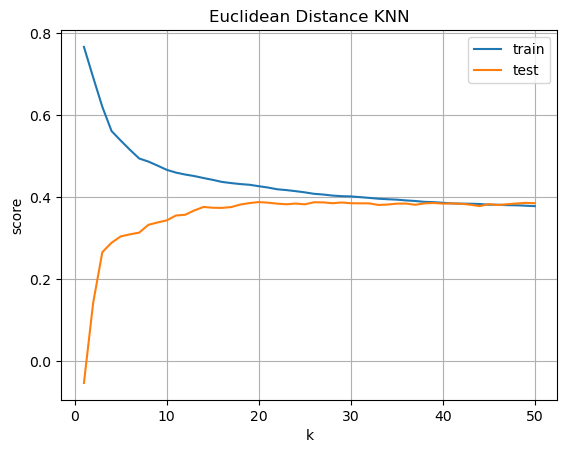

In [66]:
import matplotlib.pyplot as plt

k = np.arange(1, 51)
plt.plot(k, train_scores_euclidean, label='train')
plt.plot(k, test_scores_euclidean, label='test')
plt.xlabel('k')
plt.ylabel('score')
plt.title('Euclidean Distance KNN')
plt.legend()
plt.grid()
plt.show()

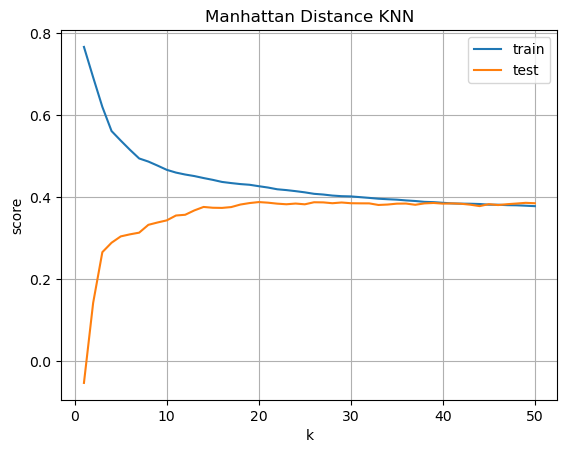

In [67]:
plt.plot(k, train_scores_manhattan, label='train')
plt.plot(k, test_scores_manhattan, label='test')
plt.xlabel('k')
plt.ylabel('score')
plt.title('Manhattan Distance KNN')
plt.legend()
plt.grid()
plt.show()

In [71]:
train_scores_distance = []
test_scores_distance = []
for k in range(1, 51):
    model = KNeighborsRegressor(n_neighbors=k, weights='distance', p=2, metric='euclidean')
        # 인접한 k개의 Euclidean 이용, 거리에 따라 가중치를 준다.
    model.fit(X_train, y_train)
    train_scores_distance.append(model.score(X_train, y_train))
    test_scores_distance.append(model.score(X_test, y_test))

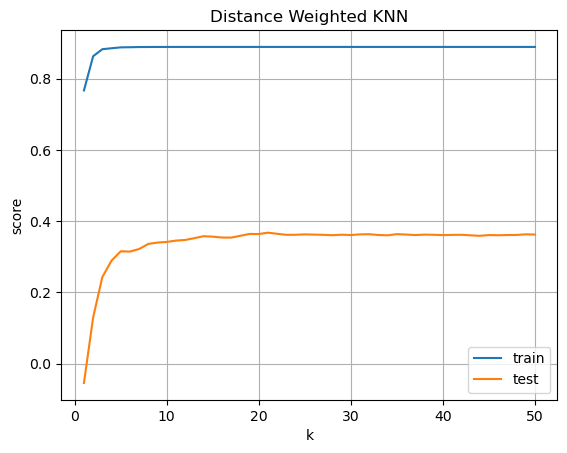

In [73]:
k = np.arange(1, 51)
plt.plot(k, train_scores_distance, label='train')
plt.plot(k, test_scores_distance, label='test')
plt.xlabel('k')
plt.ylabel('score')
plt.title('Distance Weighted KNN')
plt.legend()
plt.grid()
plt.show()

- 위의 결과로부터 가장 좋은 성능을 가지는 하이퍼 파리미터를 선택하자.

In [68]:
argmax_euclidean = np.argmax(test_scores_euclidean)
max_euclidean = np.max(test_scores_euclidean)
print(f'| Euclidean Distance KNN | k = {argmax_euclidean+1} | max score = {max_euclidean} |')

| Euclidean Distance KNN | k = 20 | max score = 0.3879839424699093 |


In [69]:
argmax_manhattan = np.argmax(test_scores_manhattan)
max_manhattan = np.max(test_scores_manhattan)
print(f'| Manhattan Distance KNN | k = {argmax_manhattan+1} | max score = {max_manhattan} |')

| Manhattan Distance KNN | k = 20 | max score = 0.3879839424699093 |


In [74]:
argmax_distance = np.argmax(test_scores_distance)
max_distance = np.max(test_scores_distance)
print(f'| Manhattan Distance KNN | k = {argmax_distance+1} | max score = {max_distance} |')

| Manhattan Distance KNN | k = 21 | max score = 0.3678424951218531 |


## 3. Evaluation

- 하이퍼 파라미터를 튜닝한 결과, weight는 uniform(가중치를 부여하지 않음. 오로지 평균으로 계산), metric은 상관없이 **k=20**일 때 KNN 모델이 가장 좋은 성능을 낸다는 것을 확인할 수 있습니다.